In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
df = pd.read_csv('/Users/test1/Documents/GitHub/JPMorgan-take-home-project/data/training_loan_data.csv', skiprows=1, header=0)

In [4]:
# df.drop(columns='id')
df = df.dropna(subset=['bad_flag'])
print(len(df))
print(f"total NA row: {df.isnull().any(axis=1).sum()}")
na_counts = df.isnull().sum()
print("count of NA each row:")
print(na_counts)
df = df.drop(columns=["mths_since_last_major_derog", "desc"])

189457
total NA row: 178594
count of NA each row:
id                                  0
member_id                           0
loan_amnt                           0
term                                0
int_rate                            0
emp_length                       7926
home_ownership                      0
annual_inc                          0
desc                           107453
purpose                             0
percent_bc_gt_75                 9038
bc_util                          9124
dti                                 0
inq_last_6mths                      0
mths_since_recent_inq           27985
revol_util                        127
total_bc_limit                   7495
mths_since_last_major_derog    156708
tot_hi_cred_lim                  7495
tot_cur_bal                     27741
application_approved_flag           0
internal_score                      0
bad_flag                            0
dtype: int64


In [5]:
column_types = {}


def process_feature(value):
    if isinstance(value, str):

        match = re.search(r'\d+\.?\d*', value)
        if match:
            return float(match.group())
        else:
            return value
    return value

for column in df.columns:
    df[column] = df[column].apply(process_feature)
    if df[column].dtype == 'object':
        column_types[column] = 'categorical'
    else:
        column_types[column] = 'numerical'

for column in df.columns:
    if column_types[column] == 'categorical':
        df[column], _ = pd.factorize(df[column])
for column in df.columns:
    if column_types[column] == 'categorical':
        df[column].fillna(3, inplace=True)
    elif column_types[column] == 'numerical':
        df[column].fillna(df[column].mean(), inplace=True)


count = Counter(df['bad_flag'])
majority_class = count.most_common()[0][0]
minority_class = count.most_common()[1][0]

C:\Users\test1\AppData\Local\Temp\ipykernel_13536\3612088973.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
C:\Users\test1\AppData\Local\Temp\ipykernel_13536\3612088973.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [6]:
from sklearn.preprocessing import StandardScaler

# df_balanced 
X = df.drop('bad_flag', axis=1).values
y = df['bad_flag'].values

# MinMaxScaler
scaler = StandardScaler()

X_normalized = scaler.fit_transform(X)

desired_majority_count = count[minority_class]
desired_minority_count = count[minority_class]

majority_samples = df[df['bad_flag'] == majority_class].sample(desired_majority_count, replace=True)
minority_samples = df[df['bad_flag'] == minority_class].sample(desired_minority_count, replace=True)

df_balanced = pd.concat([majority_samples, minority_samples])

X = df_balanced.drop('bad_flag', axis=1).values
X = scaler.fit_transform(X)

y = df_balanced['bad_flag'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [7]:
class SimpleDNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(self.output(x))
        # print(x)
        return x

model = SimpleDNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = SimpleDNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

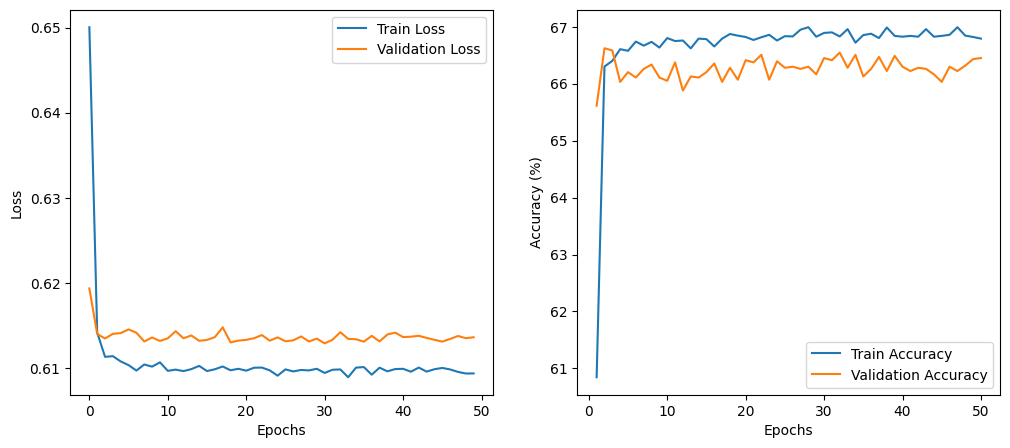

In [9]:
# train model
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        predicted_train = torch.round(outputs)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs).squeeze()
            val_loss += criterion(val_outputs, val_targets).item()
            predicted_val = torch.round(val_outputs)
            total_val += val_targets.size(0)
            correct_val += (predicted_val == val_targets).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()